In [67]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from pandas.tseries.offsets import BDay


In [68]:
data = pd.read_csv("clean_data.csv")
data.sort_values("date", inplace=True)
data.set_index("date", inplace=True)

data


,spy_adjClose,tlt_adjClose
date,,
2002-07-26,55.824445,37.841243
2002-07-29,58.543930,37.341341
2002-07-30,59.306954,37.387203
2002-07-31,59.450430,37.850416
2002-08-01,57.898298,38.065970
...,...,...
2025-07-08,620.340000,86.030000
2025-07-09,624.060000,86.930000
2025-07-10,625.820000,86.990000


The combined dataset has spy (stock) and tlt (bond) history of 24 years on business days trading. Assume the inflation rate is 2% every year. 
I will build a simulation model first and then test various combinations of stock/bond ratios: 100/0, 75/25. 50/50, 25/75, 0/100, and different withdrawal rate: 3%, 4%, 5%, 6%. At each year, I will withdraw a fixed % of the initial portfolio value, and then deduct the withdrawal, apply the return for that year based on weighted stock/bond mix. Repeat for next year, until portfolio runs out or until the end of the retirement of 24 years.

In [92]:
from dataclasses import dataclass
from datetime import datetime, timedelta

@dataclass
class SharesPrice:
    """Store the number of shares and price at a given moment."""

    shares: float
    price: float

    def value(self) -> float:
        """How much is this worth?"""

        return self.shares * self.price
    
    def deposit(self, dollars: float) -> None:
        """Add or remove the correct number of shares."""

        num_shares_to_add = dollars / self.price
        assert self.shares >= -num_shares_to_add
        self.shares += num_shares_to_add

@dataclass
class Portfolio:
    """Define a portfolio of SPY/TLT where we can deposit and withdraw money easily."""

    spy: SharesPrice
    tlt: SharesPrice
    spy_percent: float
    date: datetime

    def value(self) -> float:
        """How much money is this portfolio worth?"""

        return self.spy.value() + self.tlt.value()
    
    def deposit(self, dollars: float) -> float:
        """Add money (or remove money) from the portfolio."""

        # new_spy.value() / (new_spy.value() + new_tlt.value()) == spy_percent
        # (old_spy.value() + X) / (old_spy.value() + X + old_tlt.value() + dollars - X) == spy_percent
        # (old_spy + X) / (old_spy + old_tlt + dollars) == spy_percent
        # old_spy + X == spy_percent * (old_spy + old_tlt + dollars)
        # X = spy_percent * (old_spy + old_tlt + dollars) - old_spy
        new_spy_deposit = self.spy_percent * (self.spy.value() + self.tlt.value() + dollars) - self.spy.value()
        new_tlt_deposit = dollars - new_spy_deposit
        if abs(new_spy_deposit) > 0.0001:
            self.spy.deposit(new_spy_deposit)
        if abs(new_tlt_deposit) > 0.0001:
            self.tlt.deposit(new_tlt_deposit)


@dataclass
class Prices:
    """Store the spy and tlt prices."""

    spy: float
    tlt: float

def get_prices(date: datetime) -> Prices | None:
    key = date.date().isoformat()

    for (date, spy, tlt) in data.itertuples(name=None):
        if date == key:
            return Prices(spy, tlt)
    return None

@dataclass
class Simulate:
    """Run a single simulation."""

    portfolio: Portfolio
    start_date: datetime
    duration: timedelta
    withdrawal_rate: float
    inflation_rate: float = 1.03

    def simulate(self, first_deposit: float) -> list[tuple[datetime, float]]:
        """Run a single simulated retirement, and return the value at the end."""

        withdrawal_dollars_per_day = -first_deposit * self.withdrawal_rate / 365.25
        current_date = self.start_date
        days_skipped = 0
        plot_data = []
        while current_date < (self.start_date + self.duration):
            if current_date.month == 1 and current_date.day == 1:
                withdrawal_dollars_per_day *= self.inflation_rate

            prices = get_prices(current_date)
            if prices is None:
                days_skipped += 1
                current_date += timedelta(days=1)
                continue

            self.portfolio.date = current_date
            self.portfolio.spy.price = prices.spy
            self.portfolio.tlt.price = prices.tlt
            if first_deposit != 0:
                self.portfolio.deposit(first_deposit)
                first_deposit = 0

            withdraw = withdrawal_dollars_per_day * (1 + days_skipped)
            days_skipped = 0

            try:
                self.portfolio.deposit(withdraw)
            except:
                return plot_data
            plot_data.append((current_date, self.portfolio.value()))
            current_date += timedelta(days=1)

        return plot_data


In [70]:
# Test the simulation with a withdrawal rate of 3%, start date of 2002-7-26, spy/tlt of 75/25, initial deposit of $1,000,000.
sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), 0.75, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate=0.03)
print(sim1.simulate(1_000_000))


C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1271500878.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), 0.75, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate=0.03)


[(datetime.datetime(2002, 7, 26, 0, 0), 999917.864476386), (datetime.datetime(2002, 7, 29, 0, 0), 1032902.305309285), (datetime.datetime(2002, 7, 30, 0, 0), 1043233.9656829766), (datetime.datetime(2002, 7, 31, 0, 0), 1048275.9856831274), (datetime.datetime(2002, 8, 1, 0, 0), 1029160.0178190749), (datetime.datetime(2002, 8, 2, 0, 0), 1014411.362943874), (datetime.datetime(2002, 8, 5, 0, 0), 988810.4031881992), (datetime.datetime(2002, 8, 6, 0, 0), 1011580.1056552205), (datetime.datetime(2002, 8, 7, 0, 0), 1025334.0571080763), (datetime.datetime(2002, 8, 8, 0, 0), 1050128.7754757414), (datetime.datetime(2002, 8, 9, 0, 0), 1056692.131688331), (datetime.datetime(2002, 8, 12, 0, 0), 1052247.6500794864), (datetime.datetime(2002, 8, 13, 0, 0), 1041030.4495117846), (datetime.datetime(2002, 8, 14, 0, 0), 1070462.759699818), (datetime.datetime(2002, 8, 15, 0, 0), 1079180.295400181), (datetime.datetime(2002, 8, 16, 0, 0), 1073663.375415593), (datetime.datetime(2002, 8, 19, 0, 0), 1093068.58285730

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1899771791.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


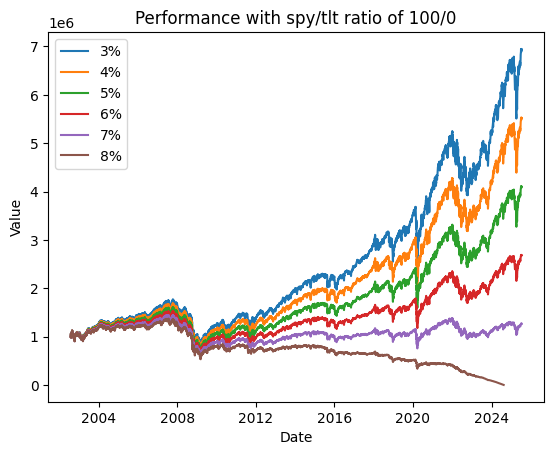

In [114]:
def plot_simulation(spy_ratio: float, withdrawal_rate: float, label):
    sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)
    value_over_time = sim1.simulate(1_000_000)

    # Unpack the data into two lists
    dates, values = zip(*value_over_time)

    plt.figure
    plt.plot(dates, values, label=label, linestyle='-' )
    
plot_simulation(1.0, 0.03, label='3%')
plot_simulation(1.0, 0.04, label='4%')
plot_simulation(1.0, 0.05, label='5%')
plot_simulation(1.0, 0.06, label='6%')
plot_simulation(1.0, 0.07, label='7%')
plot_simulation(1.0, 0.08, label='8%')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 100/0')
plt.show()



This block of code above took me 52s to finish running.
The figures indicate the amount of money left for a period of 23 years for different withdrawal rates at spy/tlt ratio of 100/0. 
At 3% withdrawal rate, with a initial of 1 million dollars in 2002, you will have about 7 million dollars in 2025.
When you increase withdrawal rate (the more money you withdraw each day), the less money you have. 
At a 8% withdrawal rate, you will run out of money in 2024.

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1899771791.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


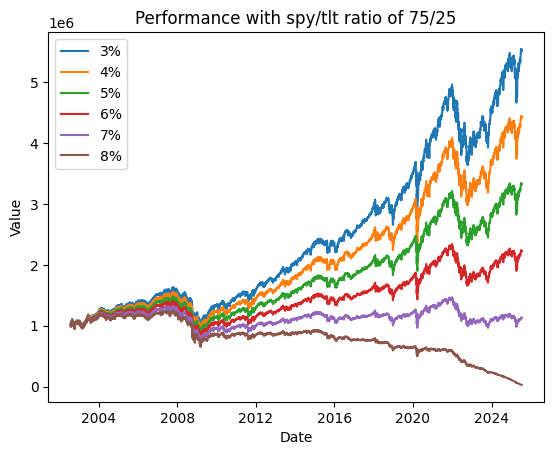

In [115]:
plot_simulation(0.75, 0.03, label='3%')
plot_simulation(0.75, 0.04, label='4%')
plot_simulation(0.75, 0.05, label='5%')
plot_simulation(0.75, 0.06, label='6%')
plot_simulation(0.75, 0.07, label='7%')
plot_simulation(0.75, 0.08, label='8%')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 75/25')
plt.show()

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1899771791.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


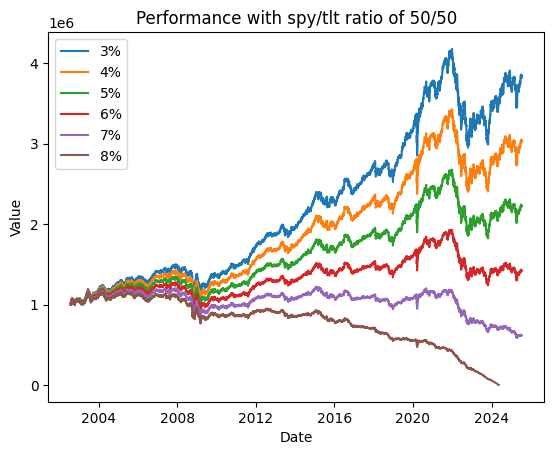

In [116]:
plot_simulation(0.5, 0.03, label='3%')
plot_simulation(0.5, 0.04, label='4%')
plot_simulation(0.5, 0.05, label='5%')
plot_simulation(0.5, 0.06, label='6%')
plot_simulation(0.5, 0.07, label='7%')
plot_simulation(0.5, 0.08, label='8%')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 50/50')
plt.show()

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1899771791.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


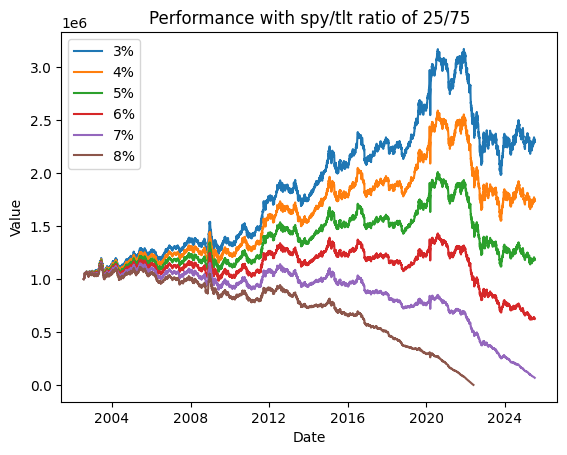

In [117]:
plot_simulation(0.25, 0.03, label='3%')
plot_simulation(0.25, 0.04, label='4%')
plot_simulation(0.25, 0.05, label='5%')
plot_simulation(0.25, 0.06, label='6%')
plot_simulation(0.25, 0.07, label='7%')
plot_simulation(0.25, 0.08, label='8%')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 25/75')
plt.show()


C:\Users\xzzlo\AppData\Local\Temp\ipykernel_23084\1899771791.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


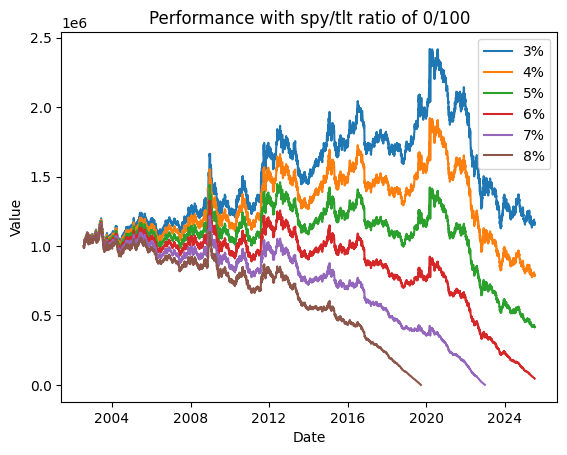

In [118]:
plot_simulation(0.0, 0.03, label='3%')
plot_simulation(0.0, 0.04, label='4%')
plot_simulation(0.0, 0.05, label='5%')
plot_simulation(0.0, 0.06, label='6%')
plot_simulation(0.0, 0.07, label='7%')
plot_simulation(0.0, 0.08, label='8%')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 0/100')
plt.show()